# HiddenLayer Graph Demo - PyTorch

In [1]:
import torch
import torchvision.models
import hiddenlayer as hl

## VGG16

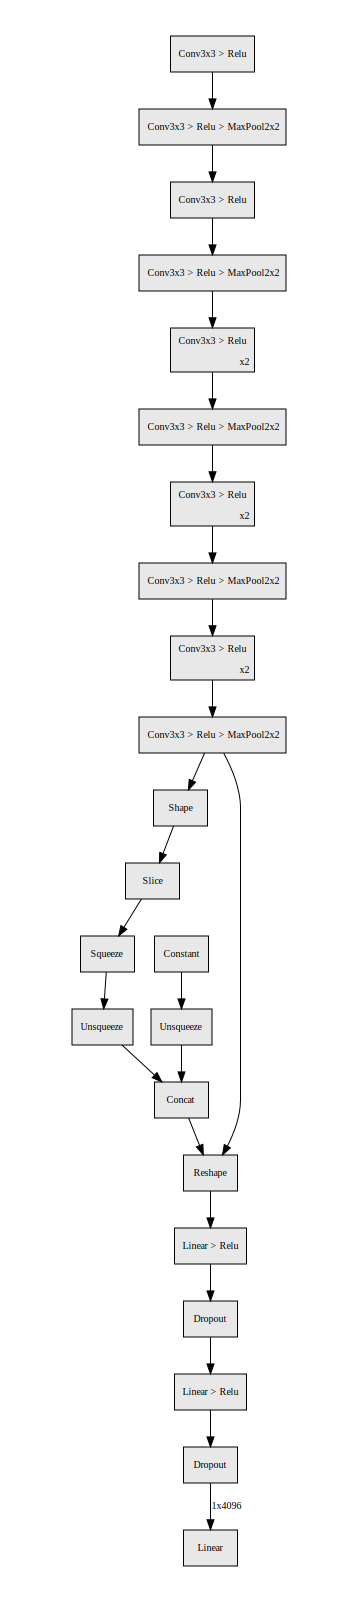

In [2]:
# VGG16 with BatchNorm
model = torchvision.models.vgg16()

# Build layout and draw
hl.Graph(model, torch.zeros([1, 3, 224, 224]))

## AlexNet

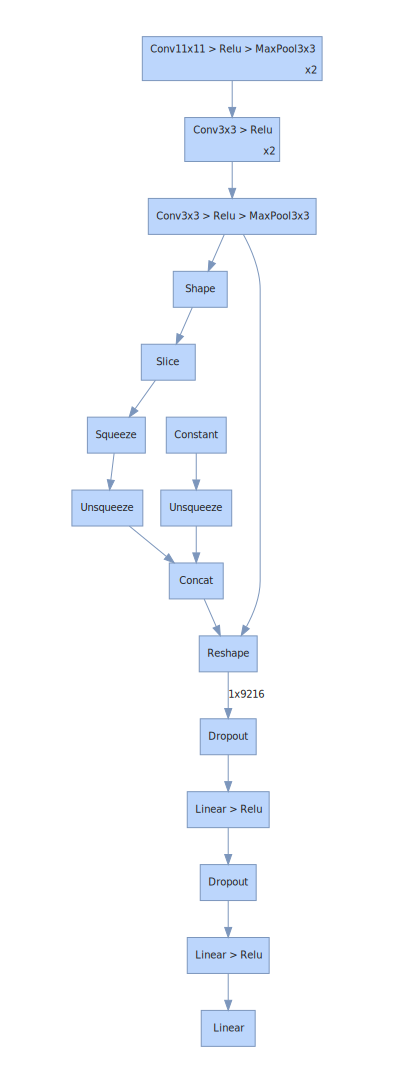

In [3]:
# AlexNet
model = torchvision.models.alexnet()

# Build layout
g = hl.Graph(model, torch.zeros([1, 3, 224, 224]))

# Update color theme
g.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
g

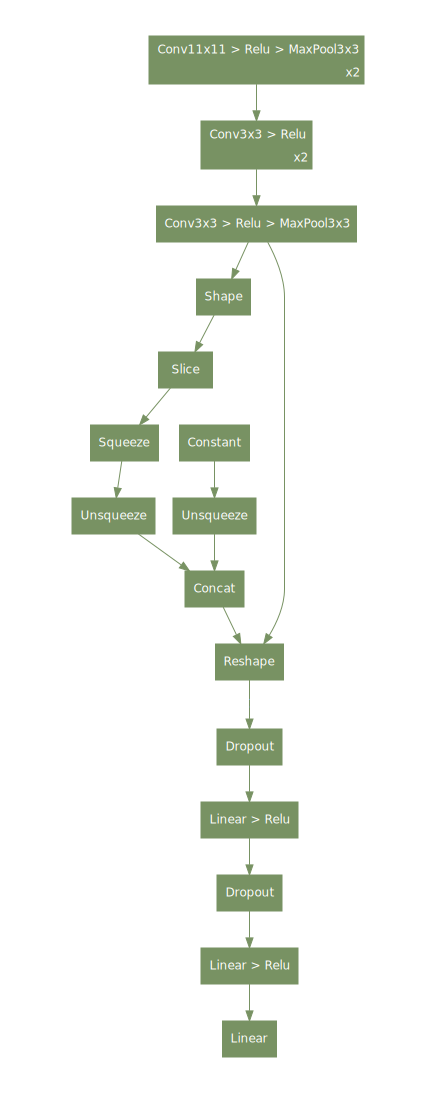

In [4]:
# Or customize the theme. It's a simple dict, defined in graph.ph
g.theme.update({
    "fill_color": "#789263",
    "outline_color": "#789263",
    "font_color": "#FFFFFF",
    "font_size": "12",
})

# Display. You can also call IPython.display(g)
g

## Transforms and Graph Expressions

Graph Expressions are like Regular Expressions for graphs. It simplifies searching the graph for nodes that fit a particular pattern. For example, the graph expression `Conv > Relu` will find all Conv layers that are followed by RELU layers. And, the expressions `Conv | MaxPool` will match any Conv and MaxPool layers that are in parallel branches (i.e. have the same parent node). And the expressions can be mixed in different ways to find more complex patterns.

Once the graph expression finds its target nodes, we use Transforms to modify them. For example, if we want to delete all nodes of type `Const`, we'll use the transform `Prune("Const")`. This graph expression here is very simple, `Const`, which matches any node with operation of type Const, and the Prune() transform deletes that node.

For examples of using tansforms, see ResNet101 below. Also, check `SIMPLICITY_TRANSFORMS` in `transforms.py`.

## ResNet101

ResNet101 is a large network, but it consists of repetitive patterns. To simplify drawing the graph, we define our own transforms that find Residual Blocks and folds them together. 

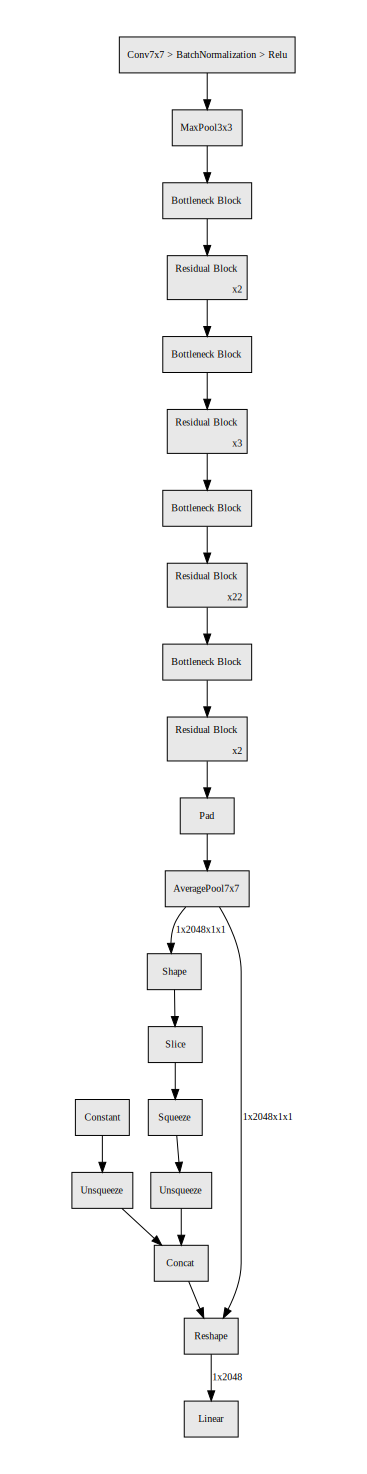

In [5]:
# Resnet101
model = torchvision.models.resnet101()

# Rather than using the default transforms, build custom ones to group
# nodes of residual and bottleneck blocks.
transforms = [
    # Fold Conv, BN, RELU layers into one
    hl.transforms.Fold("Conv > BatchNormalization > Relu", "ConvBnRelu"),
    # Fold Conv, BN layers together
    hl.transforms.Fold("Conv > BatchNormalization", "ConvBn"),
    # Fold bottleneck blocks
    hl.transforms.Fold("""
        ((ConvBnRelu > ConvBnRelu > ConvBn) | ConvBn) > Add > Relu
        """, "BottleneckBlock", "Bottleneck Block"),
    # Fold residual blocks
    hl.transforms.Fold("""ConvBnRelu > ConvBnRelu > ConvBn > Add > Relu""",
                       "ResBlock", "Residual Block"),
    # Fold repeated blocks
    hl.transforms.FoldDuplicates(),
]
# TODO: expression parser breaks if extra spaces or free lines. Track it and fix it.

# Display graph using the transforms above
g = hl.Graph(model, torch.zeros([1, 3, 224, 224]), transforms=transforms)
g

Comment out one of these lines if you want to see the original graph before transforms are applied.

In [6]:
# Without simplification transforms, but include framework transforms
# Framework transforms map PyTorch or TensorFlow graphs into a standard format
# based, mostly, on ONNX naming conventions.

# g = hl.Graph(model, torch.zeros([1, 3, 224, 224]), transforms=[])

In [7]:
# Remove all transforms completely
# Override both, simplicity transforms and framework transforms, to get
# the original raw graph.

# g = hl.Graph(model, torch.zeros([1, 3, 224, 224]), transforms=[], framework_transforms=[])